In [2]:
import numpy as np
import pandas as pd 
import copy
import matplotlib.pyplot as plt
from collections import Counter
from collections import namedtuple
from matplotlib import font_manager        #设置中文字体
my_font = font_manager.FontProperties(fname='C:/Windows/Fonts/msyh.ttc')     #传入字体的位置
from tempfile import TemporaryFile

In [2]:
face_who = 2
start = 61
end = 3000

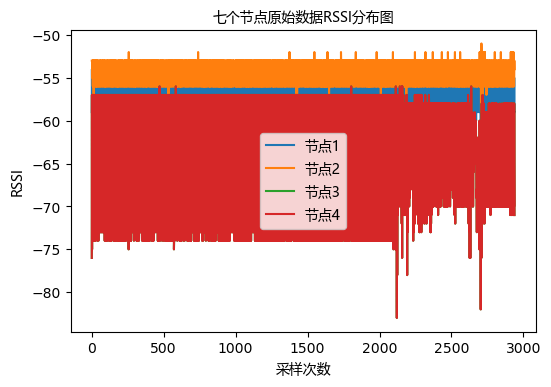

4

In [3]:
#循环读入文件
dict = {}
for i in range(4):
    #data = np.genfromtxt('D:\Python files\FaceMe\RSSI%d.txt'%(i+1))
    #data = np.genfromtxt('D:/论文/FACEME/数据/测试/RSSI%d.txt'%(i+1))
    #data = np.genfromtxt('D:\论文\源码\新建压缩文件\例程\FM+F2F+离线+在线上下界\RSSI%d.txt'%(i+1))
    #data = np.genfromtxt('D:/论文/FACEME/新建文件夹/RSSI%d.txt'%(i+1))
    #data = np.genfromtxt('D:\论文\源码\新建文件夹\9.15\RSSI%d.txt'%(i+1))
    data = np.genfromtxt('E:/fuda/HMI/新建文件夹/LW/数据/1005r005/RSSI%d.txt'%(i+1))
    
    dict['节点%d'%(i+1)] = data[start:end]
        
#len(dict['节点6'])    
df = pd.DataFrame(dict)

x = df.index.tolist()
#画图
plt.figure(dpi = 100)
for i in range(df.shape[1]):
    y = df.iloc[:,i]
    plot_fig1 = plt.plot(x,y,label = '节点{}'.format(i+1))
    plt.legend(prop = my_font, loc= 'best')
plt.xlabel('采样次数',fontproperties = my_font)
plt.ylabel('RSSI',fontproperties = my_font)
plt.title('七个节点原始数据RSSI分布图',fontproperties = my_font)
plt.show()
df.shape[1]

In [4]:
print('节点1最小值：',min(df.iloc[:,0]))
print('节点1最大值：',max(df.iloc[:,0]))
print('节点2最小值：',min(df.iloc[:,1]))
print('节点2最大值：',max(df.iloc[:,1]))
print('节点3最小值：',min(df.iloc[:,2]))
print('节点3最大值：',max(df.iloc[:,2]))
print('节点4最小值：',min(df.iloc[:,3]))
print('节点4最大值：',max(df.iloc[:,3]))

print('节点1方差：%f,均值：%f'%(np.var((df.iloc[:,0])),np.mean((df.iloc[:,0]))))
print('节点2方差：%f,均值：%f'%(np.var((df.iloc[:,1])),np.mean((df.iloc[:,1]))))
print('节点3方差：%f,均值：%f'%(np.var((df.iloc[:,2])),np.mean((df.iloc[:,2]))))
print('节点4方差：%f,均值：%f'%(np.var((df.iloc[:,3])),np.mean((df.iloc[:,3]))))

节点1最小值： -65.0
节点1最大值： -52.0
节点2最小值： -59.0
节点2最大值： -51.0
节点3最小值： -83.0
节点3最大值： -56.0
节点4最小值： -83.0
节点4最大值： -56.0
节点1方差：3.705636,均值：-57.632868
节点2方差：1.994466,均值：-54.056142
节点3方差：48.366022,均值：-64.137121
节点4方差：48.366022,均值：-64.137121


# 定义函数：寻找最小ΔR

In [5]:
def delta_min(face_who,df):
    list_df = []
    for i in range(df.shape[1]):
        sublist_df = []
        t = min(df.iloc[:,i])
        t1 = max(df.iloc[:,i])
        sublist_df.append(t)
        sublist_df.append(t1)
        list_df.append(sublist_df)
    list_df1 = []
    for j in range(len(list_df)):
        if j != face_who-1:
            t = list_df[face_who-1][0]-list_df[j][1]
            list_df1.append(t)
    return min(list_df1)  

In [6]:
delta_1 = delta_min(face_who,df)
print(delta_1)
alldata_othernode = copy.deepcopy(df)
alldata_othernode = alldata_othernode.drop(['节点%d'%(face_who)],axis=1)

alldata_othernode_upperbound = alldata_othernode.max().max()            #求除去最近节点之外的最大值
alldata_facenode_lowerbound = df[['节点%d'%(face_who)]].min().min()     #求最近节点的最小值   

print('原始整体数据最近点最小值|Rvalue|，12轮下界：',alldata_facenode_lowerbound)
print('原始整体数据除最近其他点最大|Rvalue|，12轮上界：',alldata_othernode_upperbound)


-7.0
原始整体数据最近点最小值|Rvalue|，12轮下界： -59.0
原始整体数据除最近其他点最大|Rvalue|，12轮上界： -52.0


# 均值滤波

In [7]:
def np_move_avg(a,n,mode="valid"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

# find_seconddeal_need_node 寻找第二轮所需要的节点 

In [8]:
def find_seconddeal_need_node(index,collecttime,r_everytime):
    for i in range(len(r_everytime)):
        if index == i:
            second_initial = r_everytime[i][1:collecttime+1]
    return second_initial


In [9]:
everygroup_num = 30  #分组，每组多少个数
sample_num=10        #采样数
r_firstvalue_grouped1 = []
r_Gauss_grouped1 = []
F2F_EWMA_grouped = []
F2F_mean_grouped = []
deltaR_everygroup = {'Firstvalue':[], 'Gauss':[]}
relative_Rmax_Rface1 = []
relative_Rmax_Rface2 = []
for i in range(int(df.shape[0]/everygroup_num)):
    r_firstvalue_grouped = []
    r_samplenum_grouped = {}
    r_Gauss_grouped={}
    for j in range(df.shape[1]):
        r_firstvalue_grouped.append(df.iloc[i*everygroup_num,j])       #每组第1个值
        r_samplenum_grouped[j] = df.iloc[(1+i*everygroup_num):(sample_num+1+i*everygroup_num),j].tolist() #每组除去第一个值的前10个值
        r_Gauss_grouped['节点%d'%(j+1)] = np_move_avg(r_samplenum_grouped[j],sample_num)[0]
    r_firstvalue_grouped1.append(r_firstvalue_grouped)
    r_Gauss_grouped1.append(r_Gauss_grouped)
    
    F2F_mean_grouped.append(np.mean(df.iloc[(1+i*everygroup_num):(sample_num+1+i*everygroup_num),face_who-1]))

    for m in range(sample_num):
        if m == 0:
            E = r_samplenum_grouped[face_who-1][m]
        else:
            E = r_samplenum_grouped[face_who-1][m]*0.5 + E*0.5
    F2F_EWMA_grouped.append(E)
    
    aa = pd.DataFrame(r_firstvalue_grouped1[i])
    bb = pd.DataFrame(r_Gauss_grouped1[i],index = [0])
    deltaR_everygroup['Firstvalue'].append(delta_min(face_who,aa.T))   
    deltaR_everygroup['Gauss'].append(delta_min(face_who,bb))
    
    
    #寻找最大值的索引
    index_1 = []
    Rmax_1 = max(r_firstvalue_grouped1[i])
    for k in range(len(r_firstvalue_grouped1[i])): 
        if r_firstvalue_grouped1[i][k] == Rmax_1:
            index_1.append(k)
    Rmax_num_1 = len(index_1)
    #relative_Rmax_Rface_1 = []
    if Rmax_num_1 == 1:
         relative_Rmax_Rface1.append(index_1[0]-(face_who-1)) 
    else:
        for h in range(Rmax_num_1):
            relative_Rmax_Rface1.append(index_1[h]-(face_who-1))
    #relative_Rmax_Rface1.append(relative_Rmax_Rface_1)
    
    index_2 = []
    Rmax_2 = max(r_Gauss_grouped1[i].values())
    for k in range(len(r_Gauss_grouped1[i].values())): 
        if r_Gauss_grouped1[i]['节点%d'%(k+1)] == Rmax_2:
            index_2.append(k)
    Rmax_num_2 = len(index_2)
    #relative_Rmax_Rface_2 = []
    if Rmax_num_2 == 1:
         relative_Rmax_Rface2.append(index_2[0]-(face_who-1)) 
    else:
        for h in range(Rmax_num_2):
            relative_Rmax_Rface2.append(index_2[h]-(face_who-1))
    #relative_Rmax_Rface2.append(relative_Rmax_Rface_2)

In [10]:
#横向对比
#寻找r_firstvalue_grouped1的最小值
df1 = pd.DataFrame(r_firstvalue_grouped1)
delta_1_grouped = delta_min(face_who,df1)
delta_1_grouped

-2.0

In [11]:
#横向对比
#寻找r_firstvalue_grouped1的最小值
df2 = pd.DataFrame(r_Gauss_grouped1)
delta_2_grouped = delta_min(face_who,df2)
delta_2_grouped

2.200000000000003

In [12]:
#不横向对比
delta_1_min = min( deltaR_everygroup['Firstvalue'])
delta_1_min

-2.0

In [13]:
#不横向对比
delta_2_min = min( deltaR_everygroup['Gauss'])
delta_2_min

2.5999999999999943

In [14]:
#m次滤波后目标机器2筛滤波后最近点的最小值
face_gauss_filtered_min_Rvalue = min(df2.iloc[:,face_who-1])       #df2 是r_Gauss_grouped1的DateFrame形式
face_gauss_filtered_min_Rvalue

-54.6

In [15]:
#第一次目标机器，1筛每组第一个数的最小值
face_first_value_min_Rvalue = min(df1.iloc[:,face_who-1])          #df1 是r_firstvalue_grouped1的DateFrame形式
face_first_value_min_Rvalue

-56.0

In [16]:
NearbyNode_r_Gauss_grouped = copy.deepcopy(df2)
NearbyNode_r_Gauss_grouped = NearbyNode_r_Gauss_grouped.drop(['节点%d'%(face_who)],axis=1)
Notface_gauss_filtered_max_Rvalue = NearbyNode_r_Gauss_grouped.max().max()
Notface_gauss_filtered_max_Rvalue

-56.800000000000004

In [17]:
NearbyNode_r_firstvalue_grouped = copy.deepcopy(df1)
NearbyNode_r_firstvalue_grouped = NearbyNode_r_firstvalue_grouped.drop([face_who-1],axis=1)
Notface_first_value_max_Rvalue = NearbyNode_r_firstvalue_grouped.max().max()
Notface_first_value_max_Rvalue

-54.0

In [18]:
print('deltaR1：',delta_1_min)
print('deltaR2：',delta_2_min)
print('最近点第一个值最小|Rvalue|，1轮下界：',face_first_value_min_Rvalue)
print('最近点滤波后最小|Rvalue|，2轮下界：',face_gauss_filtered_min_Rvalue)
print('除最近点其他点第一个值最大|Rvalue|，1轮上界：',Notface_first_value_max_Rvalue)
print('除最近点其他点滤波后最大|Rvalue|，2轮上界：',Notface_gauss_filtered_max_Rvalue)


deltaR1： -2.0
deltaR2： 2.5999999999999943
最近点第一个值最小|Rvalue|，1轮下界： -56.0
最近点滤波后最小|Rvalue|，2轮下界： -54.6
除最近点其他点第一个值最大|Rvalue|，1轮上界： -54.0
除最近点其他点滤波后最大|Rvalue|，2轮上界： -56.800000000000004


In [19]:
#输出Rmax位置和Rface的相对关系

shift_max = max(abs(i) for i in relative_Rmax_Rface1)
# left_shift_max = max(i for i in relative_Rmax_Rface1 if i>=0)
# right_shift_max = 0-min(i for i in relative_Rmax_Rface1 if i<=0)
# shift_max=max(left_shift_max,right_shift_max)                   #计算左移或右移的最大值
#对于最近点正好是Rmax，即移动0，也需要记录

left_right_no_shift = len(list(i for i in relative_Rmax_Rface1 if i==0))
print('从Rmax位置移动0个位置有%d组数据'%left_right_no_shift)
for i in range(shift_max):
    shift_left = len(list(j for j in relative_Rmax_Rface1 if j==i+1))
    shift_right = len(list(j for j in relative_Rmax_Rface1 if j==-(i+1)))
    print('从Rmax位置左移%d个位置有%d组数据'%(i+1,shift_left))
    print('从Rmax位置右移%d个位置有%d组数据'%(i+1,shift_right))

从Rmax位置移动0个位置有91组数据
从Rmax位置左移1个位置有0组数据
从Rmax位置右移1个位置有6组数据


In [20]:
shift_max1 = max(abs(i) for i in relative_Rmax_Rface2)
        

# left_shift_max1 = max(i for i in relative_Rmax_Rface2 if i>=0)
# right_shift_max1 = 0-min(i for i in relative_Rmax_Rface2 if i<=0)
# shift_max1 = max(left_shift_max1,right_shift_max1)                   #计算左移或右移的最大值

left_right_no_shift1 = len(list(i for i in relative_Rmax_Rface2 if i==0))
print('从Rmax位置移动0个位置有%d组数据'%left_right_no_shift1)
for i in range(shift_max1):
    shift_left1 = len(list(j for j in relative_Rmax_Rface2 if j==i+1))
    shift_right1 = len(list(j for j in relative_Rmax_Rface2 if j==-(i+1)))
    print('从Rmax位置左移%d个位置有%d组数据'%(i+1,shift_left1))
    print('从Rmax位置右移%d个位置有%d组数据'%(i+1,shift_right1))

从Rmax位置移动0个位置有97组数据


# 画图 

In [21]:
# x = df.index.tolist()
# #画图
# plt.figure(dpi = 100)
# for i in range(df.shape[1]):
#     y = df.iloc[:,i]
#     plot_fig1 = plt.plot(x,y,label = '节点{}'.format(i+1))
#     plt.legend(prop = my_font, loc= 'best')
# plt.xlabel('采样次数',fontproperties = my_font)
# plt.ylabel('RSSI',fontproperties = my_font)
# plt.title('七个节点原始数据RSSI分布图',fontproperties = my_font)
# plt.show()

In [22]:
min_average_threshold_F2F=min(F2F_mean_grouped)
mean_average_F2F=np.mean(F2F_mean_grouped)
min_EWMA_threshold_F2F=min(F2F_EWMA_grouped)
mean_EWMA_F2F=np.mean(F2F_EWMA_grouped)
print('均值滤波阈值：平均',mean_average_F2F)
print('均值滤波阈值：最小',min_average_threshold_F2F)
print('EWMA滤波阈值：平均',mean_EWMA_F2F)
print('EWMA滤波阈值：最小',min_EWMA_threshold_F2F)

均值滤波阈值：平均 -54.08144329896907
均值滤波阈值：最小 -54.6
EWMA滤波阈值：平均 -54.07081588273196
EWMA滤波阈值：最小 -55.46484375


# 保存参数结果 

In [23]:
index = 1
f_1 = open('参数设置', 'w', encoding='utf-8')
f_1.write('不同dxdy：%d\n'%index)
f_1.write('不同采样数m：%d\n'%sample_num)
f_1.write('deltaR1：%0.3f\n'%delta_1_min)
f_1.write('deltaR2：%0.3f\n'%delta_2_min)
f_1.write('最近点第一个值最小|Rvalue|，1轮下界：%0.3f\n'%face_first_value_min_Rvalue)
f_1.write('最近点滤波后最小|Rvalue|，2轮下界：%0.3f\n'%face_gauss_filtered_min_Rvalue)
f_1.write('除最近点其他点第一个值最大|Rvalue|，1轮上界：%0.3f\n'%Notface_first_value_max_Rvalue)
f_1.write('除最近点其他点滤波后最大|Rvalue|，2轮上界：%0.3f\n'%Notface_gauss_filtered_max_Rvalue)
f_1.write('均值滤波阈值：%0.3f平均\n'%mean_average_F2F)
f_1.write('均值滤波阈值：%0.3f最小\n'%min_average_threshold_F2F)
f_1.write('EWMA滤波阈值：%0.3f平均\n'%mean_EWMA_F2F)
f_1.write('EWMA滤波阈值：%0.3f最小\n'%min_EWMA_threshold_F2F)
f_1.write('原始整体数据最近点最小值|Rvalue|，12轮下界：%0.3f\n'%alldata_facenode_lowerbound)
f_1.write('原始整体数据除最近其他点最大|Rvalue|，12轮上界：%0.3f\n'%alldata_othernode_upperbound)
print(f_1)
f_1.close()

<_io.TextIOWrapper name='参数设置' mode='w' encoding='utf-8'>


# FaceME_7node_NewAlgorithm3

In [24]:
facewho=4
data_sample=30      #分组之后的每组个数
BLE_num=4
if sample_num==30:
    collecttime=29   #选取的样本数量,注意FM的样本数量要少1，第一个数用来第一次筛选
else:
    collecttime=sample_num

In [25]:
size_select_node=list(np.zeros(10).astype(int))    #存放结果
select_mode_show = []           #记录筛选情况
succeed_count=0
f_2 = open('FaceME结果', 'w', encoding='utf-8')
for  i in range(int(df.shape[0]/data_sample)):
    r_everytime = []
    first_initial = []
    second_initial = []
    gauss = []
    gauss_sort = []
    filter_result = list(np.zeros(df.shape[1]).astype(int))
    #先取出单次需要的数据个数(即分组，按循环次数),每次换组都会覆盖数据+取出每组的第一个数
    for j in range(df.shape[1]):    
        r_everytime.append(df.iloc[(i*data_sample):((i+1)*data_sample),j].tolist())
        first_initial.append(r_everytime[j][0])
    #开始第一轮筛选，先判断条件，是否第一轮可直接选出
    first_sort = sorted(first_initial,reverse=True)      #降序排列
    first_max = first_sort[0]
     
    first_index = [h for h in range(len(first_initial)) if first_initial[h]>Notface_first_value_max_Rvalue]
    first_select_node_num = len(first_index)              # 找出筛选出几个点
    
    if first_select_node_num == 1:                 
        select_mode = 1                   #筛选出一个点，直接选      
    else:
        if first_select_node_num > 0:                    
            select_mode = 2                   #筛选出 大于一个点， 需进行二次筛选
        else:
            select_mode = 3                   #没有筛选出点，需进行二次筛选
    select_mode_show.append(select_mode)  ##记录筛选情况
    
    if select_mode == 1:
        if(first_index[0] == (facewho-1)):
            succeed_count=succeed_count+1
        
        f_2.write('筛选出节点的个数：1\n')
        f_2.write('节点：%d\n'%(first_index[0]+1))
        size_select_node[first_select_node_num] = size_select_node[first_select_node_num]+1
    elif select_mode == 2:
        for k in range(first_select_node_num):
            second_initial.append(find_seconddeal_need_node(first_index[k],collecttime,r_everytime))
            gauss.append(np.mean(second_initial[k]))
    elif select_mode == 3:
        #重新第一轮筛选
        first_index = [h for h in range(len(first_initial)) if first_initial[h]>=face_first_value_min_Rvalue and first_initial[h]<0]
        first_select_node_num = len(first_index)
        for k1 in range(first_select_node_num):
            second_initial.append(find_seconddeal_need_node(first_index[k1],collecttime,r_everytime))
            gauss.append(np.mean(second_initial[k1]))
    if select_mode>1 and first_select_node_num != 0:
        #找出滤波后的最小值，为第二轮滤波做准备
        gauss_sort=sorted(gauss, reverse=True)
        filter_max = gauss_sort[0]
        #将滤波之后的值存到结果数组的对应索引的位置吗，其他地方补0
        for i1 in range(first_select_node_num):
            filter_result[first_index[i1]] = gauss[i1]
        #开始第二轮筛选，判断是否可以2轮直选，不行的话再切
        if filter_max>Notface_gauss_filtered_max_Rvalue:
            final_index = [h for h in range(len(filter_result)) if filter_result[h]>Notface_gauss_filtered_max_Rvalue and filter_result[h]<0]
        else:
            final_index = [h for h in range(len(filter_result)) if filter_result[h]>=face_gauss_filtered_min_Rvalue and filter_result[h]<0]
            
        final_index_num = len(final_index)       #仅仅找出筛选出几个点
       
        size_select_node[final_index_num] = size_select_node[final_index_num]+1
        
        f_2.write('筛选出节点的个数：%d\n'%final_index_num)
        
        for g in range(final_index_num):
            f_2.write('节点：%d\n'%(final_index[g]+1))
            if final_index[g] == (facewho-1):
                succeed_count=succeed_count+1
    elif select_mode>1 and first_select_node_num == 0:
        f_2.write('筛选出节点的个数：0\n')
        f_2.write('节点：%d\n'%0)
        size_select_node[first_select_node_num] = size_select_node[first_select_node_num]+1


In [26]:
succeed_ratio = succeed_count/(df.shape[0]/data_sample)*100
print('成功率：', succeed_ratio)
f_2.write('成功率：%d\n'%succeed_ratio)

成功率： 0.0


6

In [27]:
for n in range(len(size_select_node)):
    if size_select_node[n]!=0:
        print('筛选出：%d个节点：%d'%(n,size_select_node[n]))
        f_2.write('筛选出：%d个节点：%d'%(n,size_select_node[n]))
f_2.close()

筛选出：1个节点：97


In [28]:
succeed_ratio

0.0

In [29]:
(df.shape[0]/data_sample)

97.96666666666667